In [ ]:
!pip install scikit-multilearn
!pip install Sastrawi
!pip install swifter
!pip install nlp-id
!pip install scikit-learn --upgrade
!pip install scipy --upgrade
!pip install sklearn --upgrade
!pip install gensim
!pip install nltk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import re
import swifter
from nlp_id.lemmatizer import Lemmatizer
import gensim
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

Mounted at /content/gdrive


In [2]:
df = pd.read_csv("alodokter_final.csv")
df.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df

,id,user,title,question,question_date,answer,answer_date,doctor,topic_url,topics,topic_set,risk,year,time_to_answer
0,0,Yevie Nabella Afandi,Khasiat obat zinc sulphate,Dok saya mau tanya Anak saya kan kenak fimosis...,"23 September 2017, 18:50","Hai Yevie, Terima kasih atas pertanyaannya. Zi...","24 September 2017, 10:42",dr. Annes Waren,https://www.alodokter.com/komunitas/topic-tag/...,zinc-sulphate,zinc-sulphate,low,2017,0.0
1,1,pendys,Perbedaan jenis formula zinc,siang dokter.... dokter sayang ingin bertanya ...,"5 August 2017, 12:16","Halo Pendys, Zinc merupakan salah satu minera...","5 August 2017, 16:27",dr. Aloisia Permata Sari,https://www.alodokter.com/komunitas/topic-tag/...,zinc-sulphate,zinc-sulphate,low,2017,0.0
2,2,IriSh FairiSh,Mengkonsumsi suplemen zinc yang sudah kadaluarsa,"Malam dok, saya baru menemukan suplemen zinc s...","12 December 2018, 20:54","Hai IriSh, Terimakasih telah bertanya ke Alodo...","13 December 2018, 17:08",dr. Nadia Nurotul Fuadah,https://www.alodokter.com/komunitas/topic-tag/...,suplemen zinc-sulphate,zinc-sulphate,low,2018,0.0
3,3,dwifebiola,Keamanan konsumsi suplemen zinc saat program h...,"Dear dokter, Umur saya 24 tahun dan baru menik...","7 January 2019, 15:09","Selamat pagi, terimakasih atas pertanyaannya S...","8 January 2019, 09:32",dr. Farah Nabilla,https://www.alodokter.com/komunitas/topic-tag/...,suplemen zinc-sulphate,zinc-sulphate,low,2019,0.0
4,4,Lusiya,Suplemen apa yang banyak mengandung zinc.,Sakit flu tak kunjung sembuh disebabkan karena...,"30 March 2019, 06:05","Selamat malam, terimakasih atas pertanyaannya ...","30 March 2019, 20:25",dr. Farah Nabilla,https://www.alodokter.com/komunitas/topic-tag/...,suplemen zinc-sulphate,zinc-sulphate,low,2019,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497969,260312,chacha.12,Mata kiri selalu buram dan tak membaik dengan ...,"Hallo, dok. Jadi mata saya sebelah kiri itu sa...","2 November 2018, 09:57","Halo Chacha, terimakasih atas pertanyaannya un...","2 November 2018, 18:19",dr. Irna,https://www.alodokter.com/komunitas/topic-tag/...,ablasi-retina ulkus-kornea,ulkus-kornea,low,2018,0.0
497970,260313,Matrix-group,Munculnya bintik-bintik hitam ketika memandang...,"Dok, saya sewaktu tipes merasakan adanya perma...","8 November 2018, 13:20","Hai Matrix, Terimakasih telah bertanya ke Alod...","8 November 2018, 16:15",dr. Nadia Nurotul Fuadah,https://www.alodokter.com/komunitas/topic-tag/...,uveitis ablasi-retina,ablasi-retina,low,2018,0.0
497971,260314,Jesica Sepvana,kemungkinan bisa melihat normal lagi setelah o...,"Selamat malam dok, saya ingin bertanya, mama s...","25 June 2017, 21:56",Halo Jesica Sepvana Terima kasih atas pertanya...,"26 June 2017, 22:17",dr. Winda Indriati,https://www.alodokter.com/komunitas/topic-tag/...,ablasi-retina,ablasi-retina,low,2017,1.0
497972,260315,Megawaty,Bagaimana cara mengatasi Ablasio retina dan hu...,"Dok, saya mau tanya bagaimana cara mengatasi a...","7 April 2017, 16:33","Halo Megawaty, Ablasi retina merupakan kondis...","10 April 2017, 10:00",dr. Yosephine. S.,https://www.alodokter.com/komunitas/topic-tag/...,ablasi-retina,ablasi-retina,low,2017,2.0


In [ ]:
# df = pd.read_pickle(root_path + "alodokter_final_selected_cleaned.pkl")
# df = df.reset_index()
# df = df.iloc[:, 1:]
# df['labelmap'] = df['labelmap'].apply(lambda x: np.array(x))
# df.head()

# Label Extraction

In [3]:
# 1 record may contain >1 topics, separated by space
# Creates new column 'topics_num' to store the no. of 'topics' per record

df['topics_num'] = df.topics.apply(lambda x: len(x.split(" ")))
df.topics_num.value_counts()

2     242451
1     159513
3      72769
4      11702
5       6456
6       3206
7       1268
8        434
9        115
10        37
12         8
11         6
21         5
13         4
Name: topics_num, dtype: int64

In [4]:
# Store all topics one by one to array 'labels' (duplicates included)
labels = []

for _, record in df.iterrows():
    labels += record.topics.split(" ")

labels_set = set(labels)

In [6]:
# No. of labels
print("No. of labels in original dataset: ", len(labels_set))

No. of labels in original dataset:  1559


In [7]:
# pd.DataFrame(list(labels)).to_csv(root_path + "labels_all.csv")

In [5]:
# Count each unique topic in array 'labels'
from collections import Counter

labels_occurence = Counter(labels)
labels_occurence.most_common(10)

[('menstruasi', 31653),
 ('kehamilan', 27661),
 ('obat', 21281),
 ('asam-lambung', 17063),
 ('bayi', 15485),
 ('sakit-kepala', 11724),
 ('benjolan', 11179),
 ('kulit', 10995),
 ('alergi', 10857),
 ('kontrasepsi', 10841)]

## Pick top 10 topics as labels

In [6]:
# Pick 10 most common label occurences as labels_picked
labels_picked = [
    l[0] for l in labels_occurence.most_common()[:10]
]
# labels_picked
total_labels = len(labels_picked)
total_labels

10

In [7]:
# Numerize labels
label2idx = {k: v for v, k in enumerate(labels_picked)}
idx2label = {v: k for v, k in enumerate(labels_picked)}

idx2label

{0: 'menstruasi',
 1: 'kehamilan',
 2: 'obat',
 3: 'asam-lambung',
 4: 'bayi',
 5: 'sakit-kepala',
 6: 'benjolan',
 7: 'kulit',
 8: 'alergi',
 9: 'kontrasepsi'}

In [8]:
# labels_df = pd.DataFrame.from_dict(idx2label, orient="index")
# labels_df.rename(columns={0:'label'}, inplace=True)
# labels_df.reset_index().to_csv(root_path + 'labels.csv', index=False)

# If exists
labels_df = pd.read_csv('labels.csv')

In [9]:
labels_df

,index,label
0,0,menstruasi
1,1,kehamilan
2,2,obat
3,3,asam-lambung
4,4,bayi
5,5,sakit-kepala
6,6,benjolan
7,7,kulit
8,8,alergi
9,9,kontrasepsi


## Create `labelmap` to store hash array of labels

In [10]:
# Function to create a hashtable of 0's and 1's 
# for every numerized top 10 label encountered in each record in the dataset
import array as arr

def mapping(x):
    hashtable = np.zeros(total_labels, dtype=int)
    x_labels = x.split(" ")
    # kalau langsung if i in x, 'perawatan-kulit' terhitung sebagai 'kulit'
    for i in label2idx:
      for j in x_labels:
        if i == j:
            hashtable[label2idx[i]] = 1
    return hashtable

In [ ]:
import array as arr

def mapping(x):
    hashtable = np.zeros(total_labels, dtype=int)
    x_labels = x.split(" ")
    # kalau langsung if i in x, 'perawatan-kulit' terhitung sebagai 'kulit'
    for i in label2idx:
      for j in x_labels:
        if i == j:
            hashtable[label2idx[i]] = 1
    return hashtable

In [11]:
# Apply function mapping() to every record's 'topics' column
# Then assign hashtable to new column 'labelmap'
df['labelmap'] = df.topics.apply(lambda x: mapping(x))

## Select records with 'labelmap' sum > 0 (labelnya termasuk top 10)

In [12]:
# Create new column 'selected'
## Value 1 for records with 'labelmap' sum greater than 0 (row yang labelnya termasuk 10 most common)
## Value 0 otherwise
df['selected'] = df.labelmap.apply(lambda x: np.sum(x) > 0)

In [13]:
# Only take into consideration records with 'labelmap' sum greater than 0
df = df.loc[df.selected]
df

,id,user,title,question,question_date,answer,answer_date,doctor,topic_url,topics,topic_set,risk,year,time_to_answer,topics_num,labelmap,selected
6,6,Well Chici,Konsumsi zinc pada penderita asam lambung,Dok...saya punya riwayat asam lambung...boleh ...,"19 November 2019, 23:47","Alo Weli, Terimakasih atas pertanyaannya. Zink...","20 November 2019, 13:44",dr. Nadia Nurotul Fuadah,https://www.alodokter.com/komunitas/topic-tag/...,suplemen asam-lambung zinc-sulphate,zinc-sulphate,low,2019,0.0,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",True
7,7,Marusli8765,Tata cara dalam konsumsi Zinc sulphate,"Pagi, Dok...Saya mendapat informasi dari terap...","2 August 2019, 07:05","Alo Marusli, Zinc merupakan salah satu minera...","2 August 2019, 10:18",dr. Devika Yuldharia,https://www.alodokter.com/komunitas/topic-tag/...,diare obat zinc-sulphate,zinc-sulphate,low,2019,0.0,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",True
8,8,Hani Oktaviani,Penggunaan zinc untuk bayi usia 1 bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...","15 October 2018, 23:12","Halo Hani, Zink merupakan mineral yang juga d...","17 October 2018, 08:32",dr. Saphira Evani,https://www.alodokter.com/komunitas/topic-tag/...,bayi zinc-sulphate,zinc-sulphate,low,2018,1.0,2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",True
12,12,Izha Rin,Dampak jika salah aturan konsumsi minum obat,Selamat malam dok. saya mau tanya. ibu saya tg...,"12 February 2021, 20:40","Selamat malam, terima kasih telah bertanya di ...","12 February 2021, 22:44",dr. Amadeo Drian Basfiansa,https://www.alodokter.com/komunitas/topic-tag/...,obat zat-kimia,zat-kimia,low,2021,0.0,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",True
16,16,Fitriani Widyo Putri,Perhitungan hari pemberian dosis zinc untuk ba...,Bagaimana perhitungan 10 hari dalam mengonsums...,"26 March 2020, 07:57","Alo Fitriani, Zinc dapat membantu dalam penan...","26 March 2020, 13:57",dr. Devika Yuldharia,https://www.alodokter.com/komunitas/topic-tag/...,bayi diare zinc-sulphate,zinc-sulphate,low,2020,0.0,3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497510,259853,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,"9 February 2019, 20:03",Alo Marini ! Terima kasih atas pertanyaannya d...,"10 February 2019, 01:06",dr. Arya Pradipa Adrianto Putra,https://www.alodokter.com/komunitas/topic-tag/...,obat acetylcysteine,acetylcysteine,low,2019,0.0,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",True
497595,259938,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","23 March 2019, 19:16","Selamat siang, terimakasih atas pertanyaannya ...","24 March 2019, 11:35",dr. Farah Nabilla,https://www.alodokter.com/komunitas/topic-tag/...,obat abses-paru,abses-paru,low,2019,0.0,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",True
497605,259948,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"13 December 2020, 23:19","Alo, terimakasih atas pertanyaannya. Abses gig...","14 December 2020, 09:59",dr. Nadia Nurotul Fuadah,https://www.alodokter.com/komunitas/topic-tag/...,sakit-gigi obat abses-gigi,abses-gigi,low,2020,0.0,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",True
497628,259971,Sienna,Obat yang dapat digunakan untuk mengatasi abse...,"Dok, sblumnya gigi depan saya ngilu dan bengka...","20 August 2020, 23:59","Alo, Obat yang Anda sebutkan mengandung kaliu...","21 August 2020, 09:13",dr. Devika Yuldharia,https://www.alodokter.com/komunitas/topic-tag/...,obat abses-gigi,abses-gigi,low,2020,0.0,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",True


In [23]:
df_use = df[['user', 'title', 'question', 'answer', 'topics', 'topics_num', 'labelmap']].copy()
df_use['labels_num'] = df_use.labelmap.apply(lambda x: np.count_nonzero(x == 1))
df_use.reset_index()

# Post
# df_use = pd.read_pickle(root_path + "alodokter_final_selected_2.pkl")
# df_use = df.reset_index()
# df_use = df.iloc[:, 1:]
# df_use['labelmap'] = df_use['labelmap'].apply(lambda x: np.array(x))
# df_use

,index,user,title,question,answer,topics,topics_num,labelmap,labels_num
0,6,Well Chici,Konsumsi zinc pada penderita asam lambung,Dok...saya punya riwayat asam lambung...boleh ...,"Alo Weli, Terimakasih atas pertanyaannya. Zink...",suplemen asam-lambung zinc-sulphate,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
1,7,Marusli8765,Tata cara dalam konsumsi Zinc sulphate,"Pagi, Dok...Saya mendapat informasi dari terap...","Alo Marusli, Zinc merupakan salah satu minera...",diare obat zinc-sulphate,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
2,8,Hani Oktaviani,Penggunaan zinc untuk bayi usia 1 bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...","Halo Hani, Zink merupakan mineral yang juga d...",bayi zinc-sulphate,2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1
3,12,Izha Rin,Dampak jika salah aturan konsumsi minum obat,Selamat malam dok. saya mau tanya. ibu saya tg...,"Selamat malam, terima kasih telah bertanya di ...",obat zat-kimia,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
4,16,Fitriani Widyo Putri,Perhitungan hari pemberian dosis zinc untuk ba...,Bagaimana perhitungan 10 hari dalam mengonsums...,"Alo Fitriani, Zinc dapat membantu dalam penan...",bayi diare zinc-sulphate,3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1
...,...,...,...,...,...,...,...,...,...
152370,497510,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,obat acetylcysteine,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
152371,497595,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","Selamat siang, terimakasih atas pertanyaannya ...",obat abses-paru,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
152372,497605,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"Alo, terimakasih atas pertanyaannya. Abses gig...",sakit-gigi obat abses-gigi,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
152373,497628,Sienna,Obat yang dapat digunakan untuk mengatasi abse...,"Dok, sblumnya gigi depan saya ngilu dan bengka...","Alo, Obat yang Anda sebutkan mengandung kaliu...",obat abses-gigi,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1


In [24]:
df_use.describe()

,topics_num,labels_num
count,152375.000000,152375.000000
mean,2.245171,1.107393
std,1.118097,0.319112
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,3.000000,1.000000
max,21.000000,3.000000


## Analyze Selected Data

In [26]:
'''Get max & min length of titles'''
print("MAX length of title column")
print(df_use.title.map(lambda x: len(x)).max())
print("-----")
print("MIN length of title column")
print(df_use.title.map(lambda x: len(x)).min())

'''Get max & min length of questions'''
print("MAX length of question column")
print(df_use.question.map(lambda x: len(x)).max())
print("-----")
print("MIN length of question column")
print(df_use.question.map(lambda x: len(x)).min())

'''Get max & min length of answers'''
print("MAX length of answer column")
print(df_use.answer.map(lambda x: len(x)).max())
print("-----")
print("MIN length of answer column")
print(df_use.answer.map(lambda x: len(x)).min())

MAX length of title column
195
-----
MIN length of title column
2
MAX length of question column
22079
-----
MIN length of question column
1
MAX length of answer column
16559
-----
MIN length of answer column
1


In [ ]:
'''Get max & min length of titles'''
print("MAX length of title column")
print(df_use2.title.map(lambda x: len(x)).max())
print("-----")
print("MIN length of title column")
print(df_use2.title.map(lambda x: len(x)).min())

'''Get max & min length of questions'''
print("MAX length of question column")
print(df_use2.question.map(lambda x: len(x)).max())
print("-----")
print("MIN length of question column")
print(df_use2.question.map(lambda x: len(x)).min())

'''Get max & min length of answers'''
print("MAX length of answer column")
print(df_use2.answer.map(lambda x: len(x)).max())
print("-----")
print("MIN length of answer column")
print(df_use2.answer.map(lambda x: len(x)).min())

MAX length of title column
195
-----
MIN length of title column
2
MAX length of question column
22079
-----
MIN length of question column
1
MAX length of answer column
16559
-----
MIN length of answer column
1


In [27]:
''' Get the index of the longest titles '''
lengths = df_use['title'].str.len()
argmax = np.where(lengths == lengths.max())[0] # get the indexes
df_use.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
125990,Fadil Maulana,Apa benjolan kecil seperti jerawart di sekitar...,Dok.. di sekitar kelamin saya muncul bintilan ...,"Halo, Belum tentu benjolan di penis Anda adala...",benjolan penyakit-menular-seksual kutil-kelami...,5,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
240255,Fadil Maulana,Apa benjolan kecil seperti jerawart di sekitar...,Dok.. di sekitar kelamin saya muncul bintilan ...,"Halo, Belum tentu benjolan di penis Anda adala...",benjolan penyakit-menular-seksual kutil-kelami...,5,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1


In [41]:
''' Get the index of the longest titles '''
lengths = df_use2['title'].str.len()
argmax = np.where(lengths == lengths.max())[0] # get the indexes
df_use2.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
240255,Fadil Maulana,Apa benjolan kecil seperti jerawart di sekitar...,Dok.. di sekitar kelamin saya muncul bintilan ...,"Halo, Belum tentu benjolan di penis Anda adala...",benjolan penyakit-menular-seksual kutil-kelami...,5,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1


In [28]:
''' Get the index of the shortest titles '''
lengths = df_use['title'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df_use.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
256587,fenny_21,kb,"malam dok,saya baru 40 yang lalu melahirkan an...","Halo Fenny, terimakasih atas pertanyaannya unt...",kontrasepsi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1
258356,Devi Oktaviani,Kb,Dok umur saya 19tahun lebih 10 bulan saya akan...,"Halo Devi, Untuk menunda kehamilan bisa dilaku...",kontrasepsi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1
261579,Ayu Diah Ningsih,kb,"mlam dok,sya mau tanya,sya kb yg 3bln.tapi say...","Hai,Apabila Anda masih berada pada masa kerja...",kontrasepsi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1


In [42]:
''' Get the index of the shortest titles '''
lengths = df_use2['title'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df_use2.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
256587,fenny_21,kb,"malam dok,saya baru 40 yang lalu melahirkan an...","Halo Fenny, terimakasih atas pertanyaannya unt...",kontrasepsi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1
258356,Devi Oktaviani,Kb,Dok umur saya 19tahun lebih 10 bulan saya akan...,"Halo Devi, Untuk menunda kehamilan bisa dilaku...",kontrasepsi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1
261579,Ayu Diah Ningsih,kb,"mlam dok,sya mau tanya,sya kb yg 3bln.tapi say...","Hai,Apabila Anda masih berada pada masa kerja...",kontrasepsi,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1


In [33]:
''' Get the index of the longest questions '''
lengths = df_use['question'].str.len()
argmax = np.where(lengths == lengths.max())[0] # get the indexes
df_use.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
249333,Keyla,proses regenerasi terhadap kulit yang rusak,\u0026lt;!-- [if gte mso 9]\u0026gt;\u0026lt;x...,"Halo,Memang memiliki kulit wajah yang halus me...",kulit,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1


In [43]:
''' Get the index of the longest questions '''
lengths = df_use2['question'].str.len()
argmax = np.where(lengths == lengths.max())[0] # get the indexes
df_use2.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
249333,Keyla,proses regenerasi terhadap kulit yang rusak,\u0026lt;!-- [if gte mso 9]\u0026gt;\u0026lt;x...,"Halo,Memang memiliki kulit wajah yang halus me...",kulit,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1


In [34]:
''' Get the index of the shortest questions '''
lengths = df_use['question'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df_use.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
80156,Agung Setiawan,Penyebab munculnya benjolan pada leher,v,"Hai Ibu,Benjolan yang muncul di leher dapat di...",sakit-leher benjolan,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
86707,Yaya Ramen,Jika gigi sakit kepala ikut sakit,i,"Hai Yaya,Sakit kepala yang Anda alami disebut ...",sakit-kepala sakit-gigi,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1
464462,Agung Setiawan,Penyebab munculnya benjolan pada leher,v,"Hai Ibu,Benjolan yang muncul di leher dapat di...",sakit-leher benjolan,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1


In [44]:
''' Get the index of the shortest questions '''
lengths = df_use2['question'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df_use2.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
86707,Yaya Ramen,Jika gigi sakit kepala ikut sakit,i,"Hai Yaya,Sakit kepala yang Anda alami disebut ...",sakit-kepala sakit-gigi,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1
464462,Agung Setiawan,Penyebab munculnya benjolan pada leher,v,"Hai Ibu,Benjolan yang muncul di leher dapat di...",sakit-leher benjolan,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1


In [35]:
''' Get the index of the longest answers '''
lengths = df_use['answer'].str.len()
argmax = np.where(lengths == lengths.max())[0] # get the indexes
df_use.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
79696,Titis Yuni Kristanti,Sakit kepala jika terkena kipas angin dan seri...,"Dok saya wanita berusia 21 tahun, saya sering ...","Halo, Titis. Sakit kepala dapat disebabkan ole...",sakit-leher sakit-kepala,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1


In [45]:
''' Get the index of the longest answers '''
lengths = df_use2['answer'].str.len()
argmax = np.where(lengths == lengths.max())[0] # get the indexes
df_use2.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
79696,Titis Yuni Kristanti,Sakit kepala jika terkena kipas angin dan seri...,"Dok saya wanita berusia 21 tahun, saya sering ...","Halo, Titis. Sakit kepala dapat disebabkan ole...",sakit-leher sakit-kepala,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1


In [36]:
''' Get the index of the shortest answers '''
lengths = df_use['answer'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df_use.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
54413,olinilo,asma dan batuk hingga sakit kepala dan muntah,"Saya penderita batuk menahun, tadinya tidak te...",a,sinusitis penyakit-jantung asma asam-lambung,4,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
480120,olinilo,asma dan batuk hingga sakit kepala dan muntah,"Saya penderita batuk menahun, tadinya tidak te...",a,sinusitis penyakit-jantung asma asam-lambung,4,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1


In [46]:
''' Get the index of the shortest answers '''
lengths = df_use2['answer'].str.len()
argmax = np.where(lengths == lengths.min())[0] # get the indexes
df_use2.iloc[argmax]

,user,title,question,answer,topics,topics_num,labelmap,labels_num
480120,olinilo,asma dan batuk hingga sakit kepala dan muntah,"Saya penderita batuk menahun, tadinya tidak te...",a,sinusitis penyakit-jantung asma asam-lambung,4,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1


In [39]:
df_use2 = df_use.drop_duplicates(subset=['user', 'title', 'question', 'answer'], keep="last")
df_use2

,user,title,question,answer,topics,topics_num,labelmap,labels_num
3323,subertty,"Cara mengatasi gatal, bintik bernanah warna pu...","Dok, saya mengalami penyakit kulit di wajah aw...","Alo, terimakasih sudah bertanya di alodokter.c...",kulit gatal wajah,3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1
4094,Mflkh,Obat untuk Bekas Jerawat membuat Kulit Mengeri...,Saya seorang mahasiswi yg belum mengikuti kuli...,Halo Mflkh. Terimakasih atas pertanyaannya. Ob...,kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1
4547,Andreanputraalvaro,Benjolan daging di dalam kulit pipi,"Hallo dok, Saya mempunyai masalah masalah pada...",Halo Andreanputraalvaro....... Terimakasih ata...,benjolan wajah,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
5975,Indah Ayu,Penanganan untuk kulit wajah kering,"Assalamualaikum, dok beberapa hari ini kulit m...","Halo Indah, Saya memahami kekhawatiran Anda. ...",kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1
6017,Risna Nurwinda,Solusi pengobatan luka di wajah akibat krim pe...,"assalamualaikum dok, saya risna umur saya 19 t...",Halo Risna....... Terimakasih atas pertanyaan ...,alergi wajah,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1
...,...,...,...,...,...,...,...,...
497510,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,obat acetylcysteine,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
497595,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","Selamat siang, terimakasih atas pertanyaannya ...",obat abses-paru,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
497605,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"Alo, terimakasih atas pertanyaannya. Abses gig...",sakit-gigi obat abses-gigi,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
497628,Sienna,Obat yang dapat digunakan untuk mengatasi abse...,"Dok, sblumnya gigi depan saya ngilu dan bengka...","Alo, Obat yang Anda sebutkan mengandung kaliu...",obat abses-gigi,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1


In [54]:
labels2 = []

for _, record in df_use2.iterrows():
    labels2 += record.topics.split(" ")
    
labels2_counter = Counter(labels2)
labels2_name = [i[0] for i in labels2_counter.most_common(10)]
labels2_freq = [i[1] for i in labels2_counter.most_common(10)]

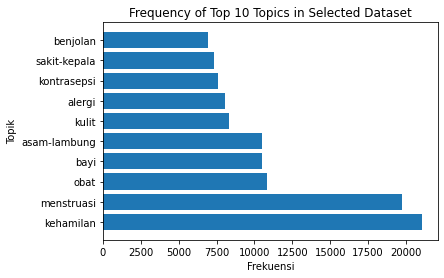

In [55]:
f, ax = plt.subplots()

plt.barh(labels2_name, labels2_freq)
plt.xlabel("Frekuensi")
plt.ylabel("Topik")
plt.title('Frequency of Top 10 Topics in Selected Dataset')

plt.show()

# Check Classes

In [51]:
Counter(combination for row in get_combination_wise_output_matrix(df_use2['labelmap'], order=1) for combination in row)

Counter({(7,): 8315,
         (6,): 6956,
         (8,): 8064,
         (1,): 21042,
         (0,): 19767,
         (4,): 10524,
         (3,): 10497,
         (2,): 10852,
         (5,): 7301,
         (9,): 7582})

In [52]:
# Check distribution of classes
vis = pd.DataFrame(df_use2.labelmap.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
vis = vis.astype(int)
vis

,menstruasi,kehamilan,obat,asam-lambung,bayi,sakit-kepala,benjolan,kulit,alergi,kontrasepsi
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
102282,0,0,1,0,0,0,0,0,0,0
102283,0,0,1,0,0,0,0,0,0,0
102284,0,0,1,0,0,0,0,0,0,0
102285,0,0,1,0,0,0,0,0,0,0


In [53]:
counts = vis.sum()
print(counts)

menstruasi      19767
kehamilan       21042
obat            10852
asam-lambung    10497
bayi            10524
sakit-kepala     7301
benjolan         6956
kulit            8315
alergi           8064
kontrasepsi      7582
dtype: int64


# [optional] Select records with threshold = 10000 for each label, supaya distribusinya lebih rata

In [22]:
labels_str = np.array(vis.columns)
threshold = 10000         # Every label has at least 10000 records

# Create dataframe for each label to store selected indexes
d = {label: pd.DataFrame() for label in labels_str}

for i in vis.columns:
  d[i] = pd.DataFrame(vis[i].values)
  d[i] = d[i].set_axis(['label'], axis=1, inplace=False)    # Rename column name as 'label'
  d[i] = d[i].loc[d[i]['label'] == 1]
  
  # Select random rows sebanyak threshold
  d[i] = d[i].sample(n=threshold)
  d[i] = d[i].reset_index()

In [23]:
d['obat']

,index,label
0,21298,1
1,32200,1
2,34488,1
3,41233,1
4,41369,1
...,...,...
9995,36158,1
9996,30978,1
9997,141982,1
9998,21509,1


In [24]:
# Store selected indexes from all label dataframes in set
ids = []
for i in vis.columns:
  ids.extend(d[i]['index'].values)

ids = list(set(ids))

In [57]:
# selected_data = df_use.iloc[ids]
# selected_data.reset_index()

selected_data = df_use2
selected_data.reset_index()

,index,user,title,question,answer,topics,topics_num,labelmap,labels_num
0,3323,subertty,"Cara mengatasi gatal, bintik bernanah warna pu...","Dok, saya mengalami penyakit kulit di wajah aw...","Alo, terimakasih sudah bertanya di alodokter.c...",kulit gatal wajah,3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1
1,4094,Mflkh,Obat untuk Bekas Jerawat membuat Kulit Mengeri...,Saya seorang mahasiswi yg belum mengikuti kuli...,Halo Mflkh. Terimakasih atas pertanyaannya. Ob...,kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1
2,4547,Andreanputraalvaro,Benjolan daging di dalam kulit pipi,"Hallo dok, Saya mempunyai masalah masalah pada...",Halo Andreanputraalvaro....... Terimakasih ata...,benjolan wajah,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
3,5975,Indah Ayu,Penanganan untuk kulit wajah kering,"Assalamualaikum, dok beberapa hari ini kulit m...","Halo Indah, Saya memahami kekhawatiran Anda. ...",kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1
4,6017,Risna Nurwinda,Solusi pengobatan luka di wajah akibat krim pe...,"assalamualaikum dok, saya risna umur saya 19 t...",Halo Risna....... Terimakasih atas pertanyaan ...,alergi wajah,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1
...,...,...,...,...,...,...,...,...,...
102282,497510,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,obat acetylcysteine,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
102283,497595,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","Selamat siang, terimakasih atas pertanyaannya ...",obat abses-paru,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
102284,497605,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"Alo, terimakasih atas pertanyaannya. Abses gig...",sakit-gigi obat abses-gigi,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
102285,497628,Sienna,Obat yang dapat digunakan untuk mengatasi abse...,"Dok, sblumnya gigi depan saya ngilu dan bengka...","Alo, Obat yang Anda sebutkan mengandung kaliu...",obat abses-gigi,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1


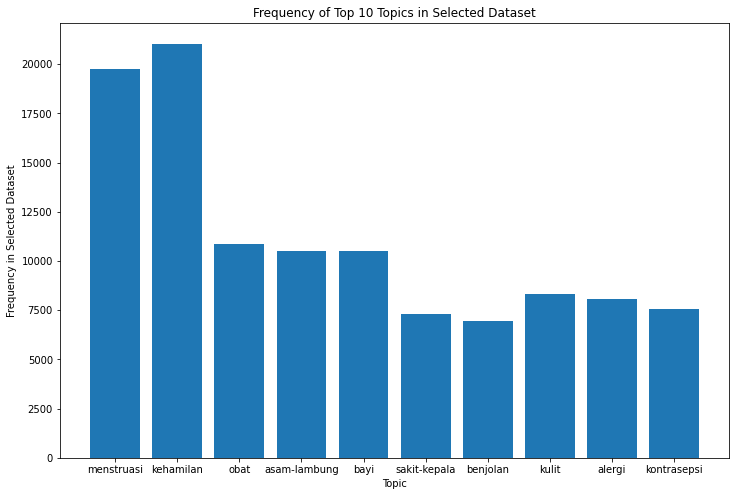

In [58]:
# Check distribution of classes
vis_selected = pd.DataFrame(selected_data.labelmap.values.tolist(), columns=['menstruasi', 'kehamilan','obat','asam-lambung','bayi','sakit-kepala','benjolan','kulit','alergi','kontrasepsi'])
vis_selected = vis_selected.astype(int)

counts = vis_selected.sum()

plt.figure(figsize=(12,8))
plt.bar(np.array(vis_selected.columns), counts)
plt.xlabel('Topic')
plt.ylabel('Frequency in Selected Dataset')
plt.title('Frequency of Top 10 Topics in Selected Dataset')
plt.show()

# Q-A text preprocessing

# Text_clean column

In [72]:
# Tokenize 'text_clean' column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(selected_data['text_clean'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# max_length = max([len(seq) for seq in sequences])
max_length = 300


embedding_matrix = np.zeros((len(word_index) + 1, id_w2v.vector_size))
oov = 0
oov_list = []

'''
For Word2Vec
'''
for word, i in word_index.items():
    try:
        embedding_matrix[i] = id_w2v[word]
    except KeyError:
        oov += 1
        oov_list.append(word)
        continue

'''
For FastText
'''
# for word, i in word_index.items():
#     if ft.wv[word] is not None:
#         embedding_matrix[i] = ft.wv[word]
#     else:
#         oov += 1

print("Out of vocab: ")
print(oov)

Found 61021 unique tokens.
Out of vocab: 
43910


In [73]:
# Tokenize 'text_clean' column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(selected_data['text_clean_fixtypo'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# max_length = max([len(seq) for seq in sequences])
max_length = 300


embedding_matrix = np.zeros((len(word_index) + 1, id_w2v.vector_size))
oov = 0
oov_list = []

'''
For Word2Vec
'''
for word, i in word_index.items():
    try:
        embedding_matrix[i] = id_w2v[word]
    except KeyError:
        oov += 1
        oov_list.append(word)
        continue

'''
For FastText
'''
# for word, i in word_index.items():
#     if ft.wv[word] is not None:
#         embedding_matrix[i] = ft.wv[word]
#     else:
#         oov += 1

print("Out of vocab: ")
print(oov)

Found 41091 unique tokens.
Out of vocab: 
8147


In [84]:
oov_list

['alodokter',
 'primolut',
 'lsdexception',
 'cetirizine',
 'unhidewhenused',
 'semihidden',
 'lansoprazole',
 'mefenamat',
 'microgynon',
 'methylprednisolone',
 'cefixime',
 'sucralfate',
 'cefadroxil',
 'ngeluarin',
 'clindamycin',
 'bebelove',
 'utrogestan',
 'diagnosanya',
 'domperidone',
 'hydrocortisone',
 'transvaginal',
 'minoxidil',
 'gentamicin',
 'museosans',
 'scabimite',
 'sangobion',
 'meloxicam',
 'stretchmark',
 'sukralfat',
 'testpeck',
 'trimaksh',
 'traneksamat',
 'amoxcilin',
 'mefenamic',
 'dokterimakasih',
 'doxycycline',
 'bioplacenton',
 'clobazam',
 'duphaston',
 'levofloxacin',
 'ngobatinnya',
 'candesartan',
 'strechmark',
 'nyembuhin',
 'pyrazinamide',
 'combantrin',
 'demacolin',
 'ngatasinnya',
 'neurobion',
 'niacinamide',
 'norethisterone',
 'albothyl',
 'lanzoprazole',
 'clopidogrel',
 'fibroadenoma',
 'cytotec',
 'azithromycin',
 'erlamycetin',
 'cetrizine',
 'nyembuhinnya',
 'piroxicam',
 'theraskin',
 'roaccutane',
 'trimakash',
 'betahistine',
 'va

## FastText

In [1]:
from gensim.models import KeyedVectors
embedding_path = "fasttext_gensim.model"
ft = KeyedVectors.load(embedding_path, mmap='r')

In [ ]:
ft["apa"]

In [5]:
word_dict = {}

for word in ft.key_to_index:
    word_dict[word] = ft[word]

In [6]:
import pickle

with open('fasttext_word_dict.pickle', 'wb') as handle:
    pickle.dump(word_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

AttributeError: 'dict' object has no attribute 'to_pickle'

In [48]:
embedding_path = "cc.id.300.bin/cc.id.300.bin"
ft = KeyedVectors.load('fasttext_gensim.model')

In [50]:
ft.most_similar("komputer")

[('computer', 0.8221502900123596),
 ('komputer.Komputer', 0.7844359278678894),
 ('komputerKomputer', 0.7773385643959045),
 ('komputer1', 0.7759630084037781),
 ('komputerkomputer', 0.7742171287536621),
 ('komputer3', 0.7694596648216248),
 ('komputeryang', 0.7546691298484802),
 ('komputer2', 0.750238835811615),
 ('komputer-', 0.7439745664596558),
 ('Komputer', 0.7383776903152466)]

## Fix typos (use Word2Vec embedding)
Source: https://medium.com/@yasirabd/spell-check-indonesia-menggunakan-pre-trained-fasttext-model-14e90a3f1ac0

In [27]:
path = 'idwiki/idwiki_word2vec_300.model'
w2v_model = Word2Vec.load(path)

In [43]:
id_w2v["komputer"]

memmap([ 1.8987454e+00,  6.3871616e-01,  6.2249232e-02, -9.8417026e-01,
         1.9442661e+00,  6.6903222e-01,  4.2731267e-01,  2.0785322e+00,
        -1.1744146e+00, -7.9381809e-02,  2.7540359e+00,  1.5211607e+00,
        -1.0047150e+00, -2.9493436e-01, -2.3271897e+00,  1.4287660e+00,
         2.1902096e-01,  6.8374705e-01, -3.9510259e-01,  4.6455598e-01,
         6.6141516e-01, -7.9703677e-01,  3.5268018e-01,  2.0759397e+00,
         9.5513713e-01,  1.8345157e+00, -2.6075218e+00,  9.1378939e-01,
        -6.4605705e-02, -1.4265233e+00,  3.7242168e-01, -4.3149695e-02,
         9.4253010e-01, -8.8542473e-01,  4.2161080e-01,  2.6199522e+00,
        -1.1772690e+00,  4.3350425e-01,  1.8209504e+00,  8.2113552e-01,
         1.1391125e+00, -1.1978949e+00, -1.2656624e+00, -1.1175097e+00,
         1.8944209e+00, -1.2154016e+00, -1.7810198e+00,  1.1399087e+00,
        -7.7121860e-01, -7.9109150e-01,  2.3734912e-01,  2.7953010e+00,
         1.1560320e+00,  2.3024731e+00,  6.6927043e-03,  1.48492

In [59]:
# word_vectors = w2v_model.wv
# word_vectors.save("id-word2vec")

# Load back with memory-mapping = read-only, shared across processes.
id_w2v = KeyedVectors.load("id-word2vec", mmap='r')
len(id_w2v)

331792

In [60]:
words = list(id_w2v.key_to_index)

w_rank = {}
for i, word in enumerate(words):
    w_rank[word] = i

# Save word rank
WORDS = w_rank

In [61]:
import itertools

ws = ["komputer", "komptr", "pusink", "lhiran", "bgmn"]

c = [correction(w) for w in ws]
c = [word for word in c if len(word)>3] # hapus kata yang <= 3 huruf
c = [word for word in c if word not in data_stopwords] # hapus stopword
result_sentence = " ".join(c).strip()
result_sentence

'komputer kompor pusing lahiran'

In [62]:
def P(word):
    # Probability of `word`
    return - WORDS.get(word, 0)

def correction(word):
    # Most probable spelling correction for word
    return max(candidates(word), key=P)

def candidates(word):
    # Generate possible spelling corrections for word
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])
    
def known(words):
    # Subset of `words` that appear in WORDS
    return set(w for w in words if w in WORDS)

def edits1(word):
    # Words that are 1 edit away from `word`
    letters = 'abcdefghjklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    # All edits that are 2 edits away from `word`
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

## Title + Question (basic preprocessing)

In [63]:
stop_factory = StopWordRemoverFactory()
more_stopwords = ['dengan', 'ia', 'bahwa', 'oleh', 'nya', 'jadi', 'untuk', 'dok', 'dokter', 'assalamualaikum', "assalamu'alaikum", 'selamat', 'hallo', 'halo']
data_stopwords = stop_factory.get_stop_words() + more_stopwords

In [64]:
lemmatizer = Lemmatizer()

def preprocess(s):
    '''Lowercase, noise removal (symbols, extra symbols, extra spaces,
    fix typos, words with length < 3, stop words), lemmatize'''

    s = s.strip().lower()   #case folding dan menghilangkan new line
    s = re.sub(r'(\W)(?=\1)', '', s) #hapus duplikat tanda baca
    s = s.replace("\n", " ") #hapus line break
    sentence = re.sub(r'[^a-zA-Z]', ' ', s) #hapus simbol dan angka
    sentence = re.sub(r"\b[a-zA-Z]\b", " ", sentence) #remove 1 alphabet
    sentence = lemmatizer.lemmatize(sentence) # lemmatisasi
    sentence = re.sub(' +', ' ', sentence) # remove double space
    sentence = sentence.split(" ")
    sentence = [word for word in sentence if len(word)>3] # hapus kata yang <= 3 huruf
    sentence = [word for word in sentence if word not in data_stopwords] # hapus stopword
    result_sentence = " ".join(sentence).strip()
    
    return result_sentence

In [65]:
selected_data['title_clean'] = selected_data.title.swifter.apply(lambda x: preprocess(x))
selected_data['question_clean'] = selected_data.question.swifter.apply(lambda x: preprocess(x))

Pandas Apply:   0%|          | 0/102287 [00:00<?, ?it/s]

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\165896652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['title_clean'] = selected_data.title.swifter.apply(lambda x: preprocess(x))


Pandas Apply:   0%|          | 0/102287 [00:00<?, ?it/s]

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\165896652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['question_clean'] = selected_data.question.swifter.apply(lambda x: preprocess(x))


In [66]:
def fix_typos(text):
    text = text.split(" ")
    words = [correction(word) for word in text]
    result = " ".join(words).strip()
    return result

In [67]:
selected_data['title_clean_fixtypo'] = selected_data.title_clean.swifter.apply(lambda x: fix_typos(x))
selected_data['question_clean_fixtypo'] = selected_data.question_clean.swifter.apply(lambda x: fix_typos(x))
selected_data

Pandas Apply:   0%|          | 0/102287 [00:00<?, ?it/s]

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\3626110018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['title_clean_fixtypo'] = selected_data.title_clean.swifter.apply(lambda x: fix_typos(x))


Pandas Apply:   0%|          | 0/102287 [00:00<?, ?it/s]

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\3626110018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['question_clean_fixtypo'] = selected_data.question_clean.swifter.apply(lambda x: fix_typos(x))


,user,title,question,answer,topics,topics_num,labelmap,labels_num,title_clean,question_clean,title_clean_fixtypo,question_clean_fixtypo
3323,subertty,"Cara mengatasi gatal, bintik bernanah warna pu...","Dok, saya mengalami penyakit kulit di wajah aw...","Alo, terimakasih sudah bertanya di alodokter.c...",kulit gatal wajah,3,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,cara atas gatal bintik nanah warna putih rasa ...,alam sakit kulit wajah awalny gatal gatal trus...,cara atas gatal bintik nanah warna putih rasa ...,alam sakit kulit wajah awalnya gatal gatal tru...
4094,Mflkh,Obat untuk Bekas Jerawat membuat Kulit Mengeri...,Saya seorang mahasiswi yg belum mengikuti kuli...,Halo Mflkh. Terimakasih atas pertanyaannya. Ob...,kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,obat bekas jerawat buat kulit kering perih,orang mahasiswi ikut kuliah sama sekali sering...,obat bekas jerawat buat kulit kering perih,orang mahasiswi ikut kuliah sama sekali sering...
4547,Andreanputraalvaro,Benjolan daging di dalam kulit pipi,"Hallo dok, Saya mempunyai masalah masalah pada...",Halo Andreanputraalvaro....... Terimakasih ata...,benjolan wajah,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,benjol daging kulit pipi,punya masalah masalah kulit pipi macam benjol ...,benjol daging kulit pipi,punya masalah masalah kulit pipi macam benjol ...
5975,Indah Ayu,Penanganan untuk kulit wajah kering,"Assalamualaikum, dok beberapa hari ini kulit m...","Halo Indah, Saya memahami kekhawatiran Anda. ...",kulit wajah,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1,tangan kulit wajah kering,beberapa hari kulit muka kering daerah pipi da...,tangan kulit wajah kering,beberapa hari kulit muka kering daerah pipi da...
6017,Risna Nurwinda,Solusi pengobatan luka di wajah akibat krim pe...,"assalamualaikum dok, saya risna umur saya 19 t...",Halo Risna....... Terimakasih atas pertanyaan ...,alergi wajah,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",1,solusi obat luka wajah akibat krim putih wajah,risna umur tanya gimana cara ngobatin luka waj...,solusi obat luka wajah akibat krim putih wajah,risna umur tanya gimana cara gobain luka wajah...
...,...,...,...,...,...,...,...,...,...,...,...,...
497510,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,obat acetylcysteine,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,mekanisme kerja obat acetylcysisteine,tanya bagaimana mekanisme kerja obat acetylsis...,mekanisme kerja obat acetylcysisteine,tanya bagaimana mekanisme kerja obat acetylsis...
497595,Aeniie Jr.,Efek samping obat pada pasien sakit paru-paru,"Selamat malam dok, saya mau bertanya..Bapak sa...","Selamat siang, terimakasih atas pertanyaannya ...",obat abses-paru,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,efek samping obat pasien sakit paru paru,malam tanya bapak hbis masuk rumah sakit fonis...,efek samping obat pasien sakit paru paru,malam tanya bapak huis masuk rumah sakit bonis...
497605,Suna,"Pemberian obat untuk anak yang sakit gigi, gus...",Dok saya mau tanya anak saya sakit gigi gusi b...,"Alo, terimakasih atas pertanyaannya. Abses gig...",sakit-gigi obat abses-gigi,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,beri obat anak sakit gigi gusi bengkak abses gigi,tanya anak sakit gigi gusi bengkak abses parah...,beri obat anak sakit gigi gusi bengkak abses gigi,tanya anak sakit gigi gusi bengkak abses parah...
497628,Sienna,Obat yang dapat digunakan untuk mengatasi abse...,"Dok, sblumnya gigi depan saya ngilu dan bengka...","Alo, Obat yang Anda sebutkan mengandung kaliu...",obat abses-gigi,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,obat atas abses gigi pecah keluar nanah,sblumnya gigi depan ngilu bengkak gitu anjur k...,obat atas abses gigi pecah keluar nanah,selamnya gigi depan ngilu bengkak gitu anjor k...


In [68]:
selected_data['text_clean'] = selected_data['title_clean'] + ' ' + selected_data['question_clean']
selected_data['text_clean_fixtypo'] = selected_data['title_clean_fixtypo'] + ' ' + selected_data['question_clean_fixtypo']

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\2072347434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['text_clean'] = selected_data['title_clean'] + ' ' + selected_data['question_clean']
C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\2072347434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['text_clean_fixtypo'] = selected_data['title_clean_fixtypo'] + ' ' + selected_data['question_clean_fixtypo']


## Answer  (summarization)
Answer column needs to be summarized, not cleaned, to maintain sentence structure

In [79]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Tugas
[nltk_data]     Akhir\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [80]:
st = sent_tokenize(selected_data['answer'].values[0])
if "Alo" in st[0]:
  st = st[1:]
st

['Zink  (seng) adalah mineral yang dibutuhkan tubuh untuk mempercepat penyembuhan luka, meningkatkan fungsi indera perasa dan indera penciuman, meningkatkan daya tahan tubuh, membantu pertumbuhan sel, sekaligus mengurai karbohidrat.',
 'Orang yang mengalami diare berat, mengalami gangguan usus sehingga menyebabkan penyerapan zink terganggu, atau habis menjalani operasi besar berisiko mengalami kekurangan zink sehingga memerlukan asupan suplemen zink tambahan.',
 'Namun, meski termasuk obat bebas, Anda tidak disarankan mengkonsumsi suplemen zink sembarangan, terlebih dalam jangka panjang, tanpa saran dokter ya.. Orang yang memiliki riwayat mengalami penyakit asam lambung (dispepsia) tidak dilarang mengkonsumsi zink.',
 'Konsumsi suplemen ini perlu dilakukan dengan sangat hati-hati pada kondisi khusus, seperti ibu hamil, ibu menyusui, anak-anak, penderita gangguan ginjal, atau juga orang dengan riwayat alergi terhadap zink.',
 'Baiknya, sebelum mengkonsumsi suplemen zink, Anda periksakan

In [ ]:
def summarize(text):
  sentences = sent_tokenize(text)
  sentences_clean = [re.sub(r'[^\w\s]','',sentence.lower()) for sentence in sentences]
  sentence_tokens = [[words for words in sentence.split(' ')] for sentence in sentences_clean]

  w2v = Word2Vec(sentence_tokens,size=1,min_count=1,iter=1000)
  sentence_embeddings = [[w2v[word][0] for word in words] for words in sentence_tokens]
  max_len = max([len(tokens) for tokens in sentence_tokens])
  sentence_embeddings = [np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in sentence_embeddings]

  similarity_matrix = np.zeros([len(sentence_tokens), len(sentence_tokens)])

  for i,row_embedding in enumerate(sentence_embeddings):
      for j,column_embedding in enumerate(sentence_embeddings):
          similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)

  nx_graph = nx.from_numpy_array(similarity_matrix)
  scores = nx.pagerank_numpy(nx_graph)

  top_sentence = {sentence:scores[index] for index,sentence in enumerate(sentences)}
  top = dict(sorted(top_sentence.items(), key=lambda x: x[1], reverse=True)[:4])
  
  summed_text = ''

  for sent in sentences:
    if sent in top.keys():
        summed_text = summed_text + sent

  return summed_text

In [ ]:
df_use['answer_clean'] = df_use.answer.apply(lambda x: summarize(x))
df_use

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.


# Export df_use

In [69]:
selected_data['labelmap'] = selected_data['labelmap'].map(list)

C:\Users\Tugas Akhir\AppData\Local\Temp\ipykernel_4676\13748515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['labelmap'] = selected_data['labelmap'].map(list)


In [70]:
selected_data.to_csv('alodokter_final_selected_5.csv', encoding='utf8',index=False)

In [71]:
selected_data.to_pickle('alodokter_final_selected_5.pkl')

# Kalau preprocessed sudah ada

In [ ]:
df = pd.read_pickle(root_path + "alodokter_final_selected_3.pkl")
df = df.reset_index()
df = df.iloc[:, 1:]
df['labelmap'] = df['labelmap'].apply(lambda x: np.array(x))
df['text_clean'] = df['title_clean'] + ' ' + df['question_clean']
df

,user,title,question,answer,topic_url,topics,labels_num,labelmap,title_clean,question_clean,selected,text_clean
0,Hani Oktaviani,Penggunaan zinc untuk bayi usia 1 bulan,"Mlm dok, sy ingin konsul anak saya usia nya 1 ...","Halo Hani, Zink merupakan mineral yang juga d...",https://www.alodokter.com/komunitas/topic-tag/...,bayi zinc-sulphate,2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",zinc bayi usia bulan,konsul anak usia bulan beberapa hari anak maaf...,True,zinc bayi usia bulan konsul anak usia bulan be...
1,Izha Rin,Dampak jika salah aturan konsumsi minum obat,Selamat malam dok. saya mau tanya. ibu saya tg...,"Selamat malam, terima kasih telah bertanya di ...",https://www.alodokter.com/komunitas/topic-tag/...,obat zat-kimia,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",dampak salah atur konsumsi minum obat,malam tanya periksa kasih obat bilang kalo min...,True,dampak salah atur konsumsi minum obat malam ta...
2,Talitha Widati,Perbedaan obat tradisional dan obat kimia,"Hallo dok, saya ingin bertanya pendapat dokter...","Alo Talitha, Terima kasih atas pertanyaannya. ...",https://www.alodokter.com/komunitas/topic-tag/...,obat herba zat-kimia,3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",beda obat tradisional obat kimia,tanya bagaimana tuju obat modern lebih baik dr...,True,beda obat tradisional obat kimia tanya bagaima...
3,Tika Kartini,Keamanan penggunaan kalung yang terbuat dari b...,apakah ada uji klinis kedokteran mengenai kalu...,"Alo, terimakasih atas pertanyaannya. Produk ka...",https://www.alodokter.com/komunitas/topic-tag/...,kulit zat-kimia,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",aman kalung buat batu germanium,klinis kena kalung,True,aman kalung buat batu germanium klinis kena ka...
4,Nurafni,Kenapa larutan infus bisa membuat tubuh menjad...,"Halo dok.. saya mau tanya, kenapa yah larutan ...","Alo, terimakasih atas pertanyaannya. Ada banya...",https://www.alodokter.com/komunitas/topic-tag/...,obat zat-kimia,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",larut infus buat tubuh lebih segar,halo tanya larut infus buat tubuh lebih segar ...,True,larut infus buat tubuh lebih segar halo tanya ...
...,...,...,...,...,...,...,...,...,...,...,...,...
88448,Enda Agustina Tarigan,Efek samping yang ditimbulkan setelah konsumsi...,"Pagi dok, ayah saya stroke karna riwayat DM da...","Selamat malam, terimakasih atas pertanyaannya ...",https://www.alodokter.com/komunitas/topic-tag/...,acyclovir obat,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",efek samping timbul konsumsi acyclovir,pagi ayah stroke karna riwayat hipertensi bebe...,True,efek samping timbul konsumsi acyclovir pagi ay...
88449,Mrs.Zaidi,Tes torch sebelum program hamil,"Salam..Dokter. Saya 28 th,8 sept 2015 lalu say...","Hai Mrs Zaidi,Terima kasih telah mempercayai k...",https://www.alodokter.com/komunitas/topic-tag/...,merencanakan-kehamilan obat acyclovir rubella ...,5,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0]",torch program hamil,salam sept lalu gugur hamil bulan beberapa min...,True,torch program hamil salam sept lalu gugur hami...
88450,Tari Lestari,Aturan minum jenis obat yang berbeda secara be...,"Selamat siang dok,bolehkah minum obat acetylcy...","Selamat malam, terima kasih telah bertanya di ...",https://www.alodokter.com/komunitas/topic-tag/...,obat acetylcysteine,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",atur minum jenis obat beda cara sama,siang minum obat acetylcysteine miniaspi sama ...,True,atur minum jenis obat beda cara sama siang min...
88451,Marini Septi Rosiana W,Mekanisme kerja obat N-acetylcysisteine.,Dok saya mau bertanya. bagaimana mekanisme ker...,Alo Marini ! Terima kasih atas pertanyaannya d...,https://www.alodokter.com/komunitas/topic-tag/...,obat acetylcysteine,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",mekanisme kerja obat acetylcysisteine,tanya bagaimana mekanisme kerja obat acetylsis...,True,mekanisme kerja obat acetylcysisteine tanya ba...


In [2]:
!python -V

Python 3.8.13
